# Trait map generation from point data

In this section we will create global trait maps based on the GBIF that we linked to the trait data from the TRY database data. Thus, for each GBIF observation in this dataset, we have a geocoordinate and a trait value. Using this, we can aggregate the individual observations in raster cells by calculating the average (or other moments, such as the standard deviation). Later, we will validate these global maps with the splot data.


## Assignments


* Create global maps based on the GBIF data and sPlot data at 0.5 and 2.0 degree resolution and assess the correlation (at the example of 2-3 traits). How do can you explain the difference?
* In addition to mean trait maps, create trait maps of the trait standard deviation
* Create a correlation matrix in which the plant traits (mean and standard deviation) are correlated against environmental variables (WorldClim, SoilGrids).
    * Which environmental drivers are the most important drivers of the functional trait space?
* In addition to trait maps (mean, standard deviation), create map different functional diversity metrics:    
    * https://www.researchgate.net/publication/233845904_A_user's_guide_to_functional_diversity_indices
    * Also consider to ask ChatGPT or Copilot on how to implement the functonal diversity metrics in Python BUT careful evaluate the formulas :-)
        Here might be an interesting ChatGPT prompt: Let´s assume I have a set of plant trait observations and species observations, which functional diversity metrics can I calculate and how can I implement them in python?
    * Maybe you can get inspiration from that R-Package: https://funecology.github.io/fundiversity/)
* Optional: Find a way to run the process on the entire GBIF archive to produce trait maps with higher global coverage (but has 240 GB)
    * https://www.gbif.org/occurrence/download?taxon_key=7707728&occurrence_status=present
* Optional: Create trait maps for different Plant Functional Types (PFT), such as grassland, tree or shrub species. The PFT information can be found in ``data/try_pft_v1.csv``

In [1]:
import pandas as pd
import numpy as np
import rasterio
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import os
import matplotlib.pyplot as plt
from typing import Union
import glob
import rioxarray

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load data

In [3]:
# Load sPlot Data
sPlot = pd.read_csv('exports/cwm_loc.csv')
sPlot.head()

C:\Users\teja\AppData\Local\Temp\ipykernel_31300\345893711.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  sPlot = pd.read_csv('exports/cwm_loc.csv')


,PlotObservationID,GIVD_ID,Dataset,Continent,Country,Biome,Date_of_recording,Latitude,Longitude,Location_uncertainty,...,Seed length,Leaf dry mass per leaf fresh mass (LDMC),Leaf nitrogen (N) per area,Leaf nitrogen/phosphorus (N/P),Leaf delta15N,Seeds per rep. unit,Leaf fresh mass,Stem conduit density,Dispersal unit length,Conduit element length
0,16,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
1,17,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
2,18,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,1.046333,-1.150683,0.024882,1.874128,-0.264750,5.633945,-4.387745,3.483073,1.470741,5.859517
3,20,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,0.126305,-1.325711,0.107715,1.999404,-0.076209,3.036499,-4.124691,5.337666,0.252902,6.570591
4,22,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,0.118110,-1.376588,0.122927,2.036662,0.073539,3.451333,-3.968128,5.380727,0.242525,6.558434


In [4]:
# Load igbif Data
gbif = pd.read_csv('exports/gbif_TRY_log.csv')
gbif.head()

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,891019304,47.684845,-122.589408,2012-02-11T00:45:13,Taxus brevifolia Nutt.,Plantae,Tracheophyta,Pinales,Taxaceae,Taxus,...,3.036512,1.699454,2.266439,5.955261,6.708805,5.204809,3.447254,3.456160,3.179939,1.006596
1,891019473,38.449024,-122.704169,2012-03-17T22:47:21,Bellis perennis L.,Plantae,Tracheophyta,Asterales,Asteraceae,Bellis,...,1.339604,0.481574,3.294559,6.104779,6.654645,9.021122,5.967409,5.978303,7.282113,2.063501
2,891021129,34.808273,-111.771296,2012-10-04T01:57:30,Canotia holacantha Torr.,Plantae,Tracheophyta,Celastrales,Celastraceae,Canotia,...,0.859522,1.543625,3.775880,6.355035,6.933957,6.574034,7.609064,7.117014,7.968083,1.177283
3,891021463,35.161813,-118.578242,2012-09-29T16:30:32,Frangula californica (Eschsch.) A.Gray,Plantae,Tracheophyta,Rosales,Rhamnaceae,Frangula,...,0.191659,2.451874,3.340559,5.753703,6.278537,8.160378,6.932882,6.901085,6.807849,1.221212
4,891021564,40.442529,-121.528058,2012-10-09T23:27:01,Monardella odoratissima Benth.,Plantae,Tracheophyta,Lamiales,Lamiaceae,Monardella,...,0.917418,0.495989,3.371571,5.810061,6.349841,8.279049,6.024887,6.374260,5.715063,1.553562


## Define the functions for rasterization

A function to rasterize the point data

In [6]:
def rasterize_points(
    points: np.ndarray, res: Union[int, float], bbox: tuple
) -> np.ndarray:
    """Rasterize points into a grid with a given resolution.

    Args:
        points (np.ndarray): Points to rasterize, with columns (x, y, value) (for
            geographic coordinates, use (lon, lat, value))
        res (Union[int, float]): Resolution of the grid
        bbox (tuple): Bounding box of the grid

    Returns:
        np.ndarray: Rasterized grid
    """
    width = int((bbox[2] - bbox[0]) / res)
    height = int((bbox[3] - bbox[1]) / res)

    rast = np.full((height, width), np.nan, dtype=np.float32)
    count_array = np.full((height, width), np.nan, dtype=np.float32)

    for x, y, value in points:
        col = int((x - bbox[0]) / res)
        row = int((bbox[3] - y) / res)
        if np.isnan(rast[row, col]):
            rast[row, col] = value
            count_array[row, col] = 1
        else:
            rast[row, col] += value
            count_array[row, col] += 1

    # Avoid division by zero
    count_array = np.nan_to_num(count_array, nan=1)

    # Calculate the average
    rast = rast / count_array

    return rast

A function to write the rasters to disk

In [7]:

def write_raster(
    raster: np.ndarray, res: Union[int, float], bbox: tuple, filename: os.PathLike
) -> None:
    """Write a raster to a GeoTIFF file.

    Args:
        raster (np.ndarray): Raster matrix to write
        res (Union[int, float]): Resolution of the raster
        bbox (tuple): Bounding box of the raster
        filename (os.PathLike): Path to the output file
    """
    width = int((bbox[2] - bbox[0]) / res)
    height = int((bbox[3] - bbox[1]) / res)

    with rio.open(
        filename,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        nodata=0,
        count=1,
        dtype=rio.float32,
        crs="EPSG:4326",
        transform=from_origin(bbox[0], bbox[3], res, res),
        compress="zstd",
    ) as dst:
        dst.write(raster, 1)

Let´s apply the function for a single trait and plot the output for a test:

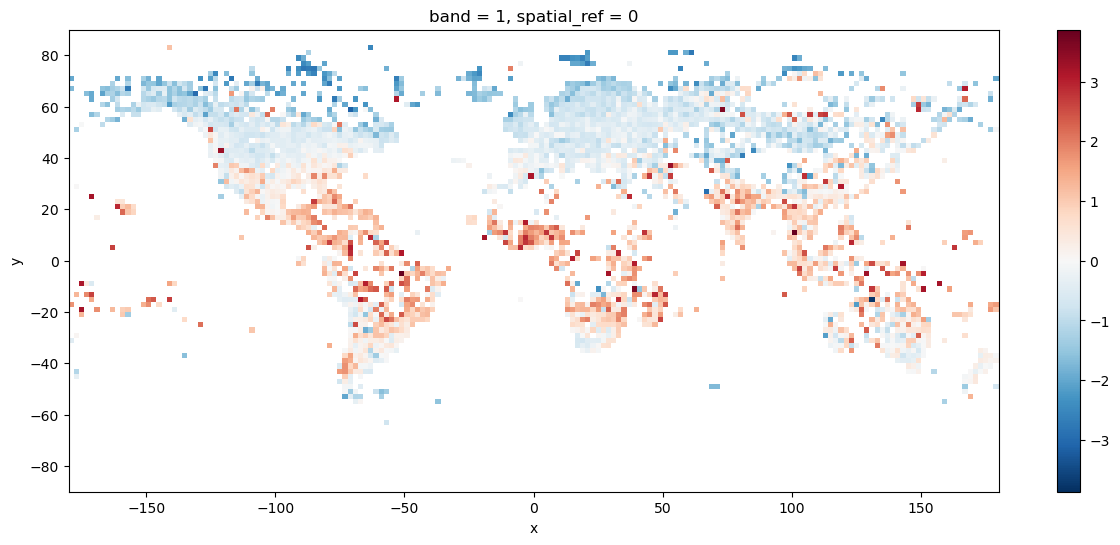

In [13]:
test = rasterize_points(gbif[["decimalLongitude", "decimalLatitude", "Plant Height"]].values, 2.0, (-180, -90, 180, 90))
os.makedirs("temp", exist_ok=True)
write_raster(test, 0.5, (-180, -90, 180, 90), "temp/test_raster_export_2_0_egree.tif")
test = rioxarray.open_rasterio("temp/test_raster_export_2_0_egree.tif")


plt.figure(figsize=(15, 6))
test.plot()

Again with a different spatial resolution (1 degree cells):

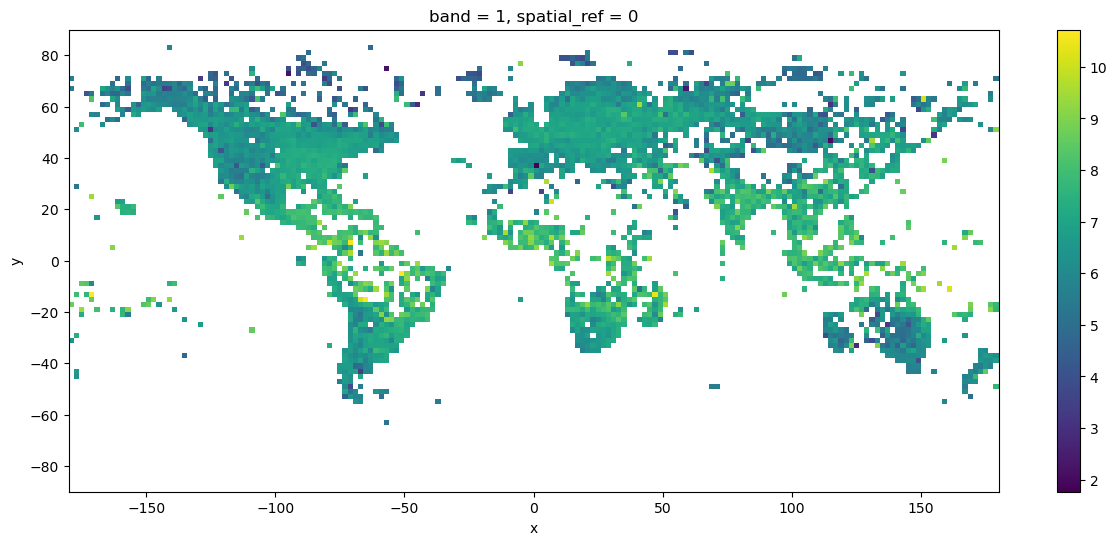

In [11]:
test = rasterize_points(gbif[["decimalLongitude", "decimalLatitude", "Pl   "]].values, 2.0, (-180, -90, 180, 90))
os.makedirs("temp", exist_ok=True)
write_raster(test, 1.0, (-180, -90, 180, 90), "temp/test_raster_export_2_0_degree.tif")
test = rioxarray.open_rasterio("temp/test_raster_export_2_0_degree.tif")


plt.figure(figsize=(15, 6))
test.plot()

## Automate the process for all traits

Create maps for all traits in sPlot

In [14]:
# select the trait colums of sPlot
traits = sPlot.columns[50:]
# define a directory for exporting the trait maps
target_dir = "exports/trait_maps_splot"
os.makedirs(target_dir, exist_ok=True)

for trait in traits:
    raster = rasterize_points(sPlot[["Longitude", "Latitude", trait]].values, 1.0, (-180, -90, 180, 90))
    # remove special characters before using the trait name as a filename
    trait = trait.replace('(', '_').replace(')', '_').replace('/', '_').replace('.', '_').replace(' ', '_')
    write_raster(raster, 0.5, (-180, -90, 180, 90), f"{target_dir}/sPlot_{trait}.tif")

Create maps for all traits in gbif

In [15]:
# select the trait colums of sPlot
traits = gbif.columns[15:]
# define a directory for exporting the trait maps
target_dir = "exports/trait_maps_gbif"
os.makedirs(target_dir, exist_ok=True)

for trait in traits:
    raster = rasterize_points(gbif[["decimalLongitude", "decimalLatitude", trait]].values, 1.0, (-180, -90, 180, 90))
    # remove special characters before using the trait name as a filename
    trait = trait.replace('(', '_').replace(')', '_').replace('/', '_').replace('.', '_').replace(' ', '_')
    write_raster(raster, 0.5, (-180, -90, 180, 90), f"{target_dir}/gbif_{trait}.tif")

## Evaluate GBIF-based trait maps with splot:

In [16]:
# open trait maps with rioxarray and calculate the correlation between the trait maps

gbif_path = glob.glob('exports/trait_maps_gbif/*height*.tif')
gbif_rast = rioxarray.open_rasterio(gbif_path[0])

splot_path = glob.glob('exports/trait_maps_splot/*height*.tif')
splot_rast = rioxarray.open_rasterio(splot_path[0])

correlation: 0.5165087664691485


Text(0, 0.5, 'trait value sPlot')

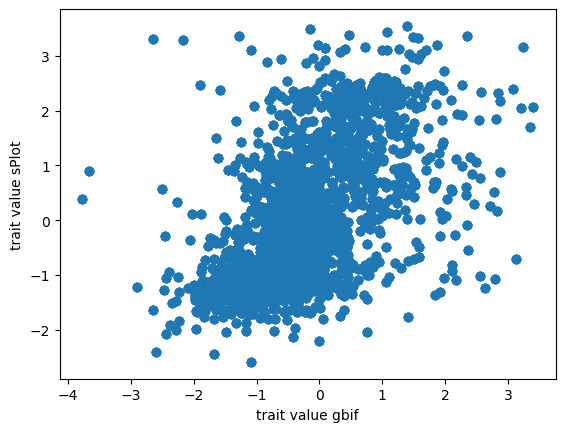

In [17]:
gbif_val = gbif_rast.values.flatten()
splot_val = splot_rast.values.flatten()

nan_gbif = np.where(np.isnan(gbif_val))
nan_splot = np.where(np.isnan(splot_val))

nan_values = np.concatenate((nan_gbif, nan_splot), axis=1)

gbif_val = np.delete(gbif_val, nan_values)
splot_val = np.delete(splot_val, nan_values)

print("correlation:", np.corrcoef(gbif_val, splot_val)[0, 1])
plt.scatter(gbif_val, splot_val)
plt.xlabel("trait value gbif")
plt.ylabel("trait value sPlot")

(note that above we loaded the .csv file with log-transformed values)